# Customer Sign-Up Behaviour & Data Quality Audit

### Loading Data

In [37]:
import pandas as pd
import re 
from datetime import datetime
import numpy.char as char
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer_signups = pd.read_csv('customer_signups.csv')
support_tickets = pd.read_csv('support_tickets.csv')

print(customer_signups.info())
print(customer_signups.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       298 non-null    object
 1   name              291 non-null    object
 2   email             266 non-null    object
 3   signup_date       298 non-null    object
 4   source            291 non-null    object
 5   region            270 non-null    object
 6   plan_selected     292 non-null    object
 7   marketing_opt_in  290 non-null    object
 8   age               288 non-null    object
 9   gender            292 non-null    object
dtypes: object(10)
memory usage: 23.6+ KB
None
  customer_id             name                 email signup_date     source  \
0   CUST00000    Joshua Bryant                   NaN         NaN  Instagram   
1   CUST00001   Nicole Stewart   nicole1@example.com  01/02/2024   LinkedIn   
2   CUST00002     Rachel Allen   rachel2@example.com  01/03

### Changing Data Types


In [38]:
customer_signups['customer_id'] = customer_signups['customer_id'].astype('string')
customer_signups['name'] = customer_signups['name'].astype('string')
customer_signups['email'] = customer_signups['email'].astype('string')
customer_signups['source'] = customer_signups['source'].astype('category')
customer_signups['region'] = customer_signups['region'].astype('category')
customer_signups['gender'] = customer_signups['gender'].astype('category')
customer_signups['plan_selected'] = customer_signups['plan_selected'].astype('category')
customer_signups['marketing_opt_in'] = customer_signups['marketing_opt_in'].astype('category')
customer_signups['age'] = pd.to_numeric(customer_signups['age'], errors='coerce')

print(customer_signups.info(20))
print(customer_signups.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customer_id       298 non-null    string  
 1   name              291 non-null    string  
 2   email             266 non-null    string  
 3   signup_date       298 non-null    object  
 4   source            291 non-null    category
 5   region            270 non-null    category
 6   plan_selected     292 non-null    category
 7   marketing_opt_in  290 non-null    category
 8   age               281 non-null    float64 
 9   gender            292 non-null    category
dtypes: category(5), float64(1), object(1), string(3)
memory usage: 14.7+ KB
None
   customer_id                 name                      email signup_date  \
0    CUST00000        Joshua Bryant                       <NA>         NaN   
1    CUST00001       Nicole Stewart        nicole1@example.com  01/02/2024   
2  

### Data cleaning

In [44]:
# Identify which column contains the date (replace if needed)
date_col = "signup_date" 

# Regex + cleaning function
def clean_date(val):
    if pd.isna(val) or str(val).strip() == "":
        return None
    val = str(val).strip()
    if re.match(r'^\d{4}-\d{2}-\d{2}$', val):
        return val
    try:
        return pd.to_datetime(val, errors="coerce").strftime("%Y-%m-%d")
    except:
        return None
customer_signups[date_col] = customer_signups[date_col].apply(clean_date)
most_common_date = customer_signups[date_col].mode().iloc[0]
customer_signups[date_col] = customer_signups[date_col].fillna(most_common_date)
customer_signups[date_col] = pd.to_datetime(customer_signups[date_col], errors='coerce')

# customer_id cleaning
customer_signups = customer_signups.drop_duplicates(subset='customer_id')
missing_indices = customer_signups['customer_id'].isna()
customer_signups.loc[missing_indices, 'customer_id'] = [
    f"CUST0030{i}" for i in range(0, missing_indices.sum())
]

# name cleaning
customer_signups['name'] = customer_signups['name'].fillna('Unknown')  # Replace <NA> or NaN
customer_signups['name'] = customer_signups['name'].astype(str).str.strip()  # Clean spaces
customer_signups['name'] = customer_signups['name'].replace('', 'Unknown')  # Replace empty strings
customer_signups['name'] = customer_signups['name'].str.title()  # Capitalize names

# email cleaning 
customer_signups['email'] = (
    customer_signups['email']
    .fillna('unknown@mailhub.org')       # handle actual NaNs
    .astype(str)
    .str.strip()
    .replace(['', 'NaN', 'na', 'nan', 'None'], 'unknown@mailhub.org')
    .str.lower()
)

# source cleaning
customer_signups['source'] = customer_signups['source'].astype(str).str.strip()
customer_signups['source'] = customer_signups['source'].replace({
'??':'YouTube',
'' :'YouTube',
'nan': 'YouTube',
'NaN': 'YouTube'
})

# region cleaning
customer_signups['region'] = customer_signups['region'].replace(['', ' '], np.nan)
customer_signups['region'] = customer_signups['region'].fillna('North')

# plan_selected cleaning
customer_signups['plan_selected'] = customer_signups['plan_selected'].replace({
'Prem':'Premium',
'basic' :'Basic',
'PRO' :'Pro'
})
customer_signups['plan_selected'] = customer_signups['plan_selected'].astype(str).str.strip()
customer_signups.loc[customer_signups['plan_selected'] == 'UnknownPlan', 'plan_selected'] = 'Premium'
mask = customer_signups['plan_selected'].isin(['Nan', 'NaN', ''])
random_choices = np.random.choice(['Basic', 'Pro'], size=mask.sum(), p=[0.5, 0.5])
customer_signups.loc[mask, 'plan_selected'] = random_choices
customer_signups['plan_selected'] = customer_signups['plan_selected'].str.capitalize()
customer_signups['plan_selected'] = customer_signups['plan_selected'].astype('category')

# marketing_opt_in
customer_signups['marketing_opt_in'] = customer_signups['marketing_opt_in'].replace({
    'Nil': 'No',
    'None': 'No',
    'nan': 'Yes',
    'NaN': 'Yes',
    '': 'Yes'
})
customer_signups['marketing_opt_in'] = customer_signups['marketing_opt_in'].fillna('Yes')
customer_signups['marketing_opt_in'] = customer_signups['marketing_opt_in'].astype(str).str.strip()



# age cleaning
customer_signups['age'] = pd.to_numeric(customer_signups['age'], errors='coerce')
customer_signups['age'] = customer_signups['age'].fillna(customer_signups['age'].median())
customer_signups['age'] = customer_signups['age'].round().astype(int)
customer_signups = customer_signups[customer_signups['age'] != 206]

# gender cleaning
customer_signups['gender'] = customer_signups['gender'].astype(str).str.strip()
customer_signups['gender'] = customer_signups['gender'].replace({
    'male': 'Male',
    'MALE': 'Male',
    'female': 'Female',
    'FEMALE': 'Female',
    'other': 'Other',
    '123' : 'Female',
    'non-binary': 'Non-Binary'
})
# Replace blanks, 'nan', and 'NaN' → 'Male'
customer_signups['gender'] = customer_signups['gender'].replace(
    ['', 'nan', 'NaN', str(np.nan)], 'Male'
)

print(customer_signups.head(20))

   customer_id                 name                      email signup_date  \
0    CUST00000        Joshua Bryant        unknown@mailhub.org  2024-02-02   
1    CUST00001       Nicole Stewart        nicole1@example.com  2024-01-02   
2    CUST00002         Rachel Allen        rachel2@example.com  2024-01-03   
3    CUST00003      Zachary Sanchez       zachary3@mailhub.org  2024-01-04   
4    CUST00004              Unknown       matthew4@mailhub.org  2024-01-05   
5    CUST00005        John Gonzales          john5@mailhub.org  2024-01-06   
6    CUST00006        Crystal Mason       crystal6@mailhub.org  2024-01-07   
7    CUST00007       Michael Bailey       michael7@mailhub.org  2024-01-08   
8    CUST00008        Bianca Morris        bianca8@example.com  2024-01-09   
9    CUST00009       Cindy Anderson        unknown@mailhub.org  2024-01-10   
10   CUST00010          Kendra Gill       kendra10@mailhub.org  2024-01-11   
11   CUST00011          Lisa Miller         lisa11@mailhub.org  

### Data Quality Summary

In [45]:
missing_counts = customer_signups.isnull().sum()
missing_percentage = (customer_signups.isnull().sum() / len(customer_signups)) * 100

print(missing_counts, "\n")
print(missing_percentage, "\n")

duplicates_removed = customer_signups.duplicated(subset='customer_id').sum()
print(duplicates_removed, "\n")

print(f"Unique Plan Values After Cleaning: {customer_signups['plan_selected'].unique()}")
print(f"Unique Gender Values After Cleaning: {customer_signups['gender'].unique()}")
print(f"Unique Source Values After Cleaning: {customer_signups['source'].unique()}")


customer_id         0
name                0
email               0
signup_date         0
source              0
region              0
plan_selected       0
marketing_opt_in    0
age                 0
gender              0
age_group           0
dtype: int64 

customer_id         0.0
name                0.0
email               0.0
signup_date         0.0
source              0.0
region              0.0
plan_selected       0.0
marketing_opt_in    0.0
age                 0.0
gender              0.0
age_group           0.0
dtype: float64 

0 

Unique Plan Values After Cleaning: ['Basic', 'Premium', 'Pro']
Categories (3, object): ['Basic', 'Premium', 'Pro']
Unique Gender Values After Cleaning: ['Female' 'Male' 'Non-Binary' 'Other']
Unique Source Values After Cleaning: ['Instagram' 'LinkedIn' 'Google' 'YouTube' 'Facebook' 'Referral']


### Summary Outputs

In [46]:
weekly_customer_signups = customer_signups.groupby(
    pd.Grouper(key='signup_date', freq='W')
)['customer_id'].count()
print("Weekly Sign-Ups:\n", weekly_customer_signups)

print("Sign-ups by Source:\n", customer_signups['source'].value_counts())
print("Sign-ups by Region:\n", customer_signups['region'].value_counts())
print("Sign-ups by Plan:\n", customer_signups['plan_selected'].value_counts())

marketing_by_gender = customer_signups.groupby('gender')['marketing_opt_in'].value_counts().unstack(fill_value=0)
print("Marketing Opt-in by Gender:\n", marketing_by_gender)

print("Age Summary:\n", customer_signups['age'].describe())
print("Null Count in Age:\n", customer_signups['age'].isna().sum())


Weekly Sign-Ups:
 signup_date
2024-01-07     6
2024-01-14     7
2024-01-21     7
2024-01-28     7
2024-02-04    14
2024-02-11     7
2024-02-18     7
2024-02-25     7
2024-03-03     7
2024-03-10     7
2024-03-17     7
2024-03-24     6
2024-03-31     6
2024-04-07     7
2024-04-14     7
2024-04-21     7
2024-04-28     7
2024-05-05     6
2024-05-12     7
2024-05-19     7
2024-05-26     7
2024-06-02     7
2024-06-09     6
2024-06-16     7
2024-06-23     7
2024-06-30     7
2024-07-07     7
2024-07-14     7
2024-07-21     6
2024-07-28     6
2024-08-04     7
2024-08-11     6
2024-08-18     7
2024-08-25     7
2024-09-01     7
2024-09-08     7
2024-09-15     7
2024-09-22     7
2024-09-29     7
2024-10-06     7
2024-10-13     7
2024-10-20     6
2024-10-27     6
Freq: W-SUN, Name: customer_id, dtype: int64
Sign-ups by Source:
 source
YouTube      73
Google       50
Referral     48
Instagram    48
Facebook     40
LinkedIn     39
Name: count, dtype: int64
Sign-ups by Region:
 region
North      94
Ea

### Business Questions

In [47]:
last_month = customer_signups['signup_date'].max() - pd.DateOffset(months=1)
last_month_data = customer_signups[customer_signups['signup_date'] >= last_month]
top_source_last_month = last_month_data['source'].value_counts().idxmax()
print(f"Top acquisition source last month: {top_source_last_month}")

print("\nMissing region count:", customer_signups['region'].isna().sum())
print("Unique region values:\n", customer_signups['region'].value_counts(dropna=False))

customer_signups['age_group'] = pd.cut(
    customer_signups['age'],
    bins=[0, 25, 35, 46, 60],
    labels=['<25', '25-35', '36-46', '47-60']
)
marketing_by_age = pd.crosstab(
    customer_signups['age_group'],
    customer_signups['marketing_opt_in'],
    normalize='index'
)
print("\nMarketing Opt-in by Age Group:\n", marketing_by_age)

plan_by_age = pd.crosstab(
    customer_signups['age_group'],
    customer_signups['plan_selected']
)
print("\nPlan by Age Group:\n", plan_by_age)


Top acquisition source last month: YouTube

Missing region count: 0
Unique region values:
 region
North      94
East       61
South      59
West       45
Central    39
Name: count, dtype: int64

Marketing Opt-in by Age Group:
 marketing_opt_in        No       Yes
age_group                           
<25               0.552632  0.447368
25-35             0.522936  0.477064
36-46             0.500000  0.500000
47-60             0.507937  0.492063

Plan by Age Group:
 plan_selected  Basic  Premium  Pro
age_group                         
<25               30       22   24
25-35             36       37   36
36-46             11       25   14
47-60             20       21   22


### Visualizations

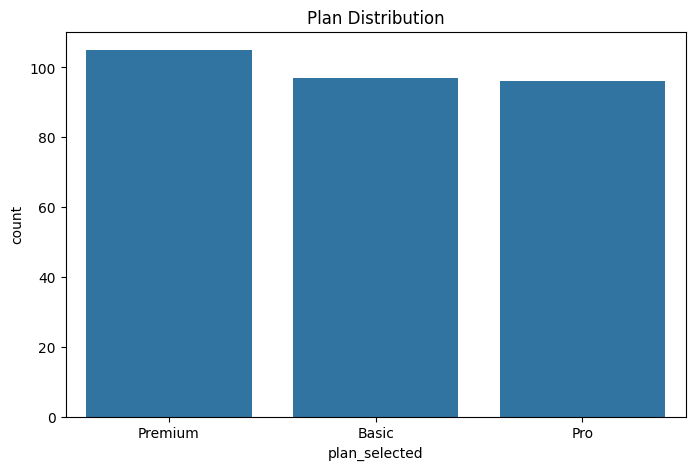

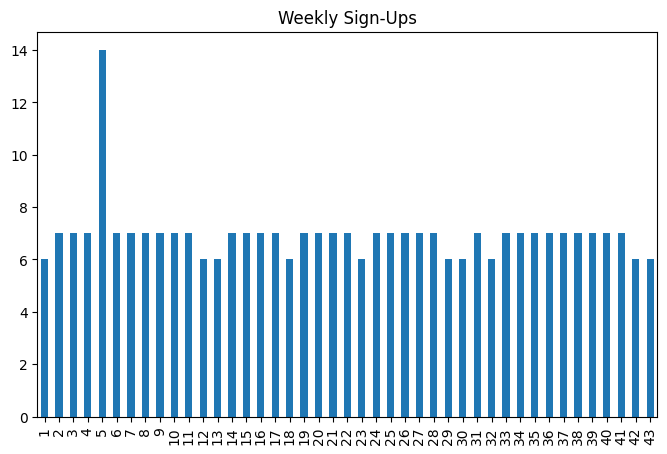

In [48]:

plt.figure(figsize=(8,5))
sns.countplot(data=customer_signups, x='plan_selected', order=customer_signups['plan_selected'].value_counts().index)
plt.title("Plan Distribution")
plt.show()

weekly_customer_signups.index = [f"{i+1}" for i in range(len(weekly_customer_signups))]
plt.figure(figsize=(8,5))
weekly_customer_signups.plot(kind='bar', title='Weekly Sign-Ups')
plt.show()


### Optional Stretch Task

In [49]:
support_tickets['ticket_date'] = pd.to_datetime(support_tickets['ticket_date'], errors='coerce')
merged = pd.merge(support_tickets, customer_signups, on='customer_id', how='left')
merged['days_to_ticket'] = (merged['ticket_date'] - merged['signup_date']).dt.days
within_2_weeks = merged[(merged['days_to_ticket'] >= 0) & (merged['days_to_ticket'] <= 14)]
print("Support activity within 2 weeks:", within_2_weeks.groupby(['plan_selected','region']).size())

# Save cleaned data
customer_signups.to_csv('customer_signups_cleaned.csv', index=False)


Support activity within 2 weeks: plan_selected  region 
Basic          Central    0
               East       2
               North      2
               South      7
               West       4
Premium        Central    1
               East       0
               North      4
               South      0
               West       6
Pro            Central    2
               East       6
               North      7
               South      2
               West       1
dtype: int64


C:\Users\Kelvin Adeborna\AppData\Local\Temp\ipykernel_5320\741501094.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("Support activity within 2 weeks:", within_2_weeks.groupby(['plan_selected','region']).size())
